In [45]:
from lifelines import KaplanMeierFitter # install
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import pymc as pm # install
import arviz as az

import seaborn as sns # install

from sklearn.metrics import mean_squared_error # install

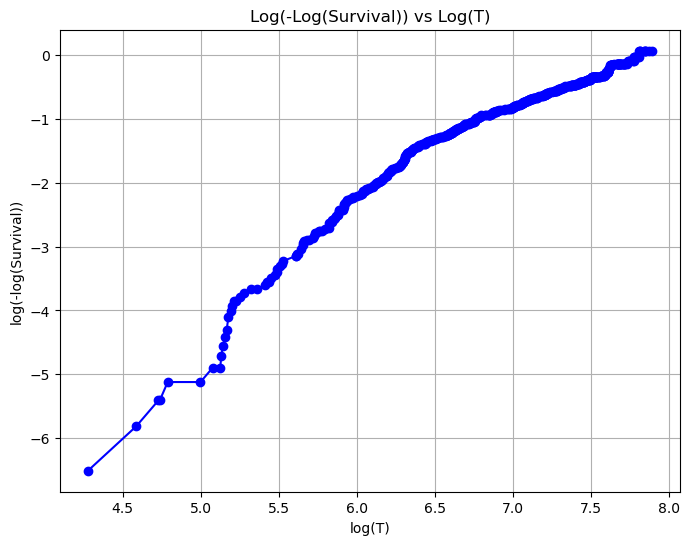

In [3]:
# Load the data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Sort data by time
time_events = data[['time', 'status']].sort_values(by='time')
unique_times = time_events['time'].unique()

# Initialize counts
n_at_risk = len(time_events)
survival_prob = 1.0
survival_function = []

# Calculate the survival function
for t in unique_times:
    n_events = time_events[(time_events['time'] == t) & (time_events['status'] == 1)].shape[0]
    survival_prob *= (1 - n_events / n_at_risk)
    n_at_risk -= time_events[time_events['time'] == t].shape[0]
    survival_function.append((t, survival_prob))

# Convert survival function into DataFrame
survival_df = pd.DataFrame(survival_function, columns=['time', 'survival'])

# Filter out survival probabilities that are exactly 0 or 1
survival_df = survival_df[(survival_df['survival'] > 0) & (survival_df['survival'] < 1)]

# Calculate log(-log(survival)) and log(time)
survival_df['log_time'] = np.log(survival_df['time'])
survival_df['log_minus_log_survival'] = np.log(-np.log(survival_df['survival']))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(survival_df['log_time'], survival_df['log_minus_log_survival'], marker='o', linestyle='-', color='b')
plt.xlabel('log(T)')
plt.ylabel('log(-log(Survival))')
plt.title('Log(-Log(Survival)) vs Log(T)')
plt.grid(True)
plt.show()


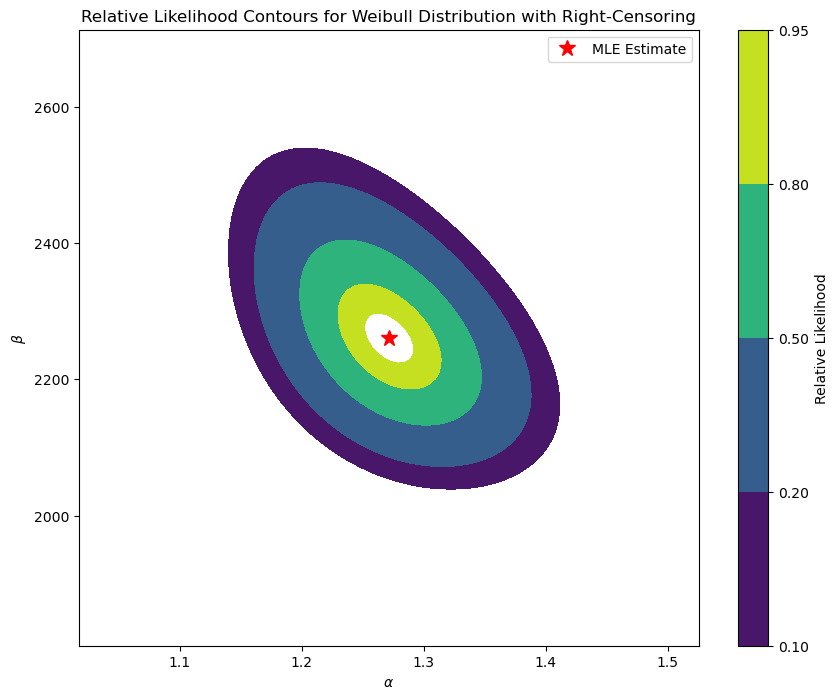

Estimated alpha: 1.2712736195283298
Estimated beta: 2261.048524878582


In [4]:
# Load data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Extract survival times and censoring indicators
survival_times = data['time'].values
censored = data['status'].values  # Assuming 1 for event and 0 for censoring

# Step 1: Initial estimates based on quantiles
# Estimate of beta
beta_initial = np.quantile(survival_times, 1 - np.exp(-1))

# Estimate of alpha
median_y = np.median(survival_times)
alpha_initial = np.log(np.log(2)) / np.log(median_y / beta_initial)

# Define the log-likelihood function for the Weibull distribution with right-censoring
def weibull_log_likelihood(params, times, censored):
    alpha, beta = params
    term1 = censored * (np.log(alpha) - alpha * np.log(beta) + (alpha - 1) * np.log(times))
    term2 = -((times / beta) ** alpha)
    log_likelihood = np.sum(term1 + term2)
    return -log_likelihood  # Return negative for minimization

# Step 2: Maximize the log-likelihood function to find the best alpha and beta
initial_params = [alpha_initial, beta_initial]
result = minimize(weibull_log_likelihood, initial_params, args=(survival_times, censored),
                  method='L-BFGS-B', bounds=[(0.01, None), (0.01, None)])

# Extract optimized alpha and beta values
alpha_mle, beta_mle = result.x

# Step 3: Generate a grid of alpha and beta values around the MLE estimates for contour plot
alpha_range = np.linspace(alpha_mle * 0.8, alpha_mle * 1.2, 100)
beta_range = np.linspace(beta_mle * 0.8, beta_mle * 1.2, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)

# Calculate relative likelihood values for each pair in the grid
log_likelihood_values = np.zeros_like(alpha_grid)

for i in range(alpha_grid.shape[0]):
    for j in range(alpha_grid.shape[1]):
        log_likelihood_values[i, j] = -weibull_log_likelihood(
            [alpha_grid[i, j], beta_grid[i, j]], survival_times, censored
        )

# Step 4: Convert log-likelihood to relative likelihood
max_log_likelihood = np.max(log_likelihood_values)
relative_likelihood_values = np.exp(log_likelihood_values - max_log_likelihood)

# Step 5: Plot the relative likelihood contour map
plt.figure(figsize=(10, 8))
contour = plt.contourf(alpha_grid, beta_grid, relative_likelihood_values, levels=[0.1, 0.2, 0.5, 0.8, 0.95], cmap='viridis')
plt.colorbar(contour, label='Relative Likelihood')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Relative Likelihood Contours for Weibull Distribution with Right-Censoring')
plt.plot(alpha_mle, beta_mle, 'r*', markersize=12, label='MLE Estimate')
plt.legend()
plt.show()

print(f"Estimated alpha: {alpha_mle}")
print(f"Estimated beta: {beta_mle}")


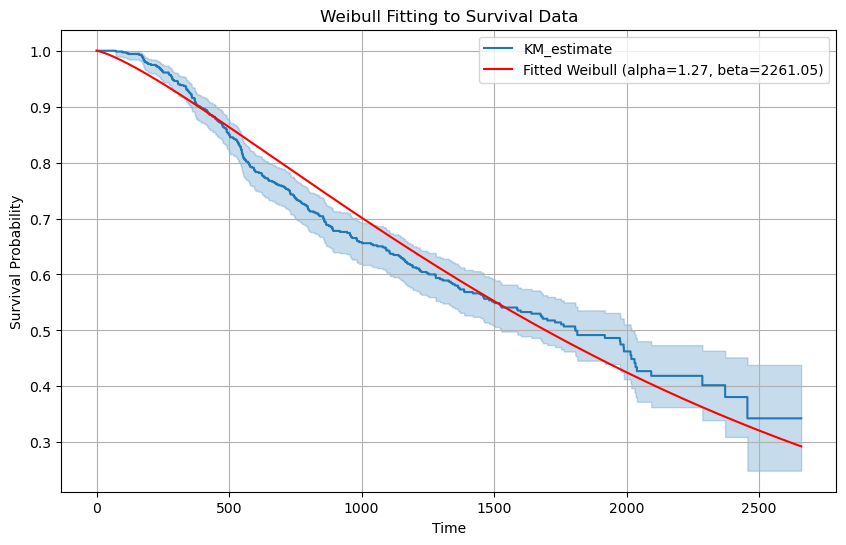

In [5]:
# Fit the Kaplan-Meier estimator to the data
kmf = KaplanMeierFitter()
kmf.fit(data['time'], event_observed=data['status'])

# Fit the Weibull distribution to data with estimated alpha and beta
def weibull_cdf(t, alpha, beta):
    return 1 - np.exp(-(t / beta) ** alpha)

# Generate data points for plotting the fitted Weibull survival curve
time_range = np.linspace(0, max(survival_times), 500)
survival_curve = 1 - weibull_cdf(time_range, alpha_mle, beta_mle)

# Plot the Kaplan-Meier estimator and the fitted Weibull survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.plot(time_range, survival_curve, 'r-', label=f'Fitted Weibull (alpha={alpha_mle:.2f}, beta={beta_mle:.2f})')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Weibull Fitting to Survival Data')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(data['time'], data['status'], label='WeibullFitter')
wbf.print_summary()

<lifelines.WeibullFitter:"WeibullFitter", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2637.28
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 2259.85    114.89         2034.68         2485.03
rho_       1.27      0.06            1.15            1.40

         cmp to     z      p  -log2(p)
lambda_    1.00 19.66 <0.005    283.48
rho_       1.00  4.29 <0.005     15.78
---
AIC = 5278.55

## Add some Bayesian flour

In [7]:
import pandas as pd
df = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')

# Filter out censored data (keep only events)
df_events = df[df["status"] == 1]
T = df_events["time"]
T

0      1814
1      2018
2       712
3      1807
4       772
       ... 
679     866
680     504
683     769
684     727
685    1701
Name: time, Length: 299, dtype: int64

In [8]:
# Use only event times (status == 1)
with pm.Model() as WeibullModel:
    alpha = pm.Exponential("alpha", alpha_mle)  # Shape parameter
    beta = pm.Exponential("beta", beta_mle)  # Scale parameter
    
    # Weibull likelihood with filtered survival times
    time = pm.Weibull("time", alpha, beta, observed=T)

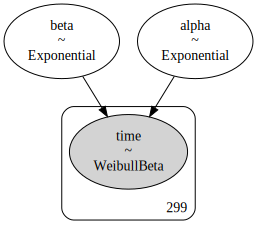

In [9]:
pm.model_to_graphviz(WeibullModel)

In [10]:
with WeibullModel:
    TraceHeight = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

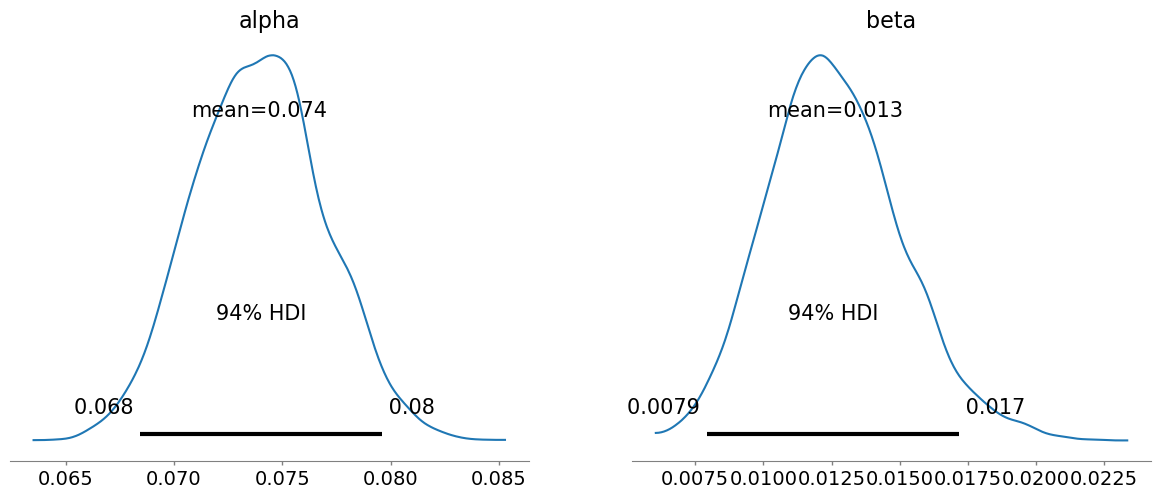

In [11]:
az.plot_posterior(TraceHeight)

## Now considered censored data

In [30]:
ObservedTimes = data.loc[data["status"] == 1, "time"].values
CensoredTimes = data.loc[data["status"] == 0, "time"].values

# Get indices of all observed times
observed_indices = np.arange(len(ObservedTimes))

# Set seed for reproducibility
np.random.seed(42)

# Randomly select 75 indices for the test set
test_indices = np.random.choice(observed_indices, size=75, replace=False)

# Select test and train times based on indices
ObservedTimes_test = ObservedTimes[test_indices]
ObservedTimes_train = np.delete(ObservedTimes, test_indices)

In [31]:
# Weibull log-survivor function
def WeibullLogSurvivor(t, alpha, beta):
    return -1/beta**alpha * t**alpha

# Weibull survivor function
def WeibullSurvivor(t, alpha, beta):
    return np.exp(WeibullLogSurvivor(t, alpha, beta))

# Time quantile
def TimeQuantile(p, alpha, beta):
    return beta * (-np.log(1-p))**(1/alpha)

In [32]:
with pm.Model() as WeibullBayesian:
    Alpha = pm.HalfFlat("Alpha") # Non-informative prior
    Lambda = pm.Gamma("Lambda", alpha=1, beta=0.001) # Vague prior
    #lam = pm.HalfFlat("lambda") # Non-informative prior
    Beta = pm.Deterministic("Beta", 1/Lambda**(1/Alpha))

    # Time quantile
    MedianTime = pm.Deterministic("MedianTime", TimeQuantile(0.5, Alpha, Beta))

    TimeObs = pm.Weibull("TimesObserved", Alpha, Beta, observed=ObservedTimes_train)
    TimeCens = pm.Potential("TimesCensored", WeibullLogSurvivor(CensoredTimes, Alpha, Beta))

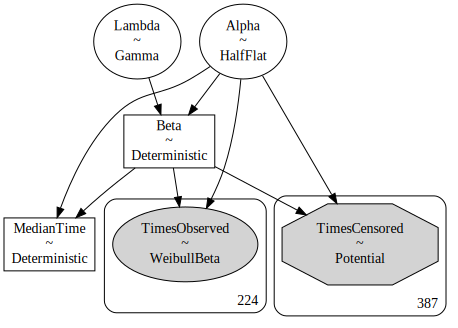

In [33]:
pm.model_to_graphviz(WeibullBayesian)

In [34]:
with WeibullBayesian:
    TraceWeibull = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Lambda]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [35]:
ALPHA=0.11
az.summary(TraceWeibull, hdi_prob=1-ALPHA)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Alpha,1.282,0.076,1.150,1.391,0.004,0.003,458.0,431.0,1.01
Lambda,0.000,0.000,0.000,0.000,0.000,0.000,462.0,431.0,1.01
Beta,2698.167,170.498,2428.836,2960.192,5.168,3.368,1145.0,1425.0,1.00
MedianTime,2024.384,111.428,1851.178,2196.711,2.403,1.907,2257.0,2298.0,1.00


In [36]:
az.summary(TraceWeibull, kind="stats", stat_focus="median", hdi_prob=1-ALPHA)

,median,mad,eti_5.5%,eti_94.5%
Alpha,1.281,0.052,1.163,1.407
Lambda,0.000,0.000,0.000,0.000
Beta,2684.943,111.230,2448.635,2987.120
MedianTime,2015.670,72.557,1860.044,2210.928


array([<Axes: title={'center': 'Alpha'}>,
       <Axes: title={'center': 'Beta'}>], dtype=object)

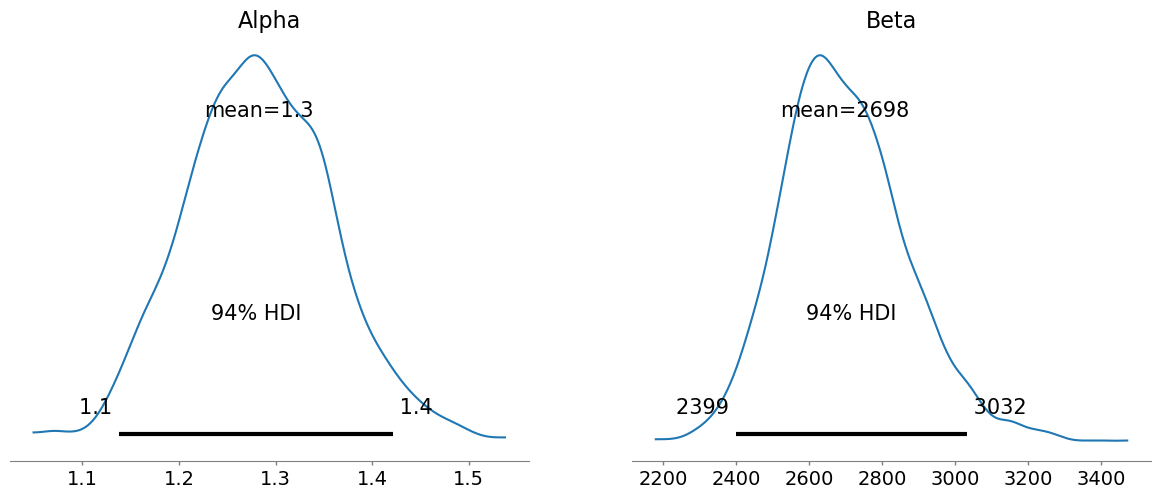

In [37]:
az.plot_posterior(TraceWeibull, var_names=["Alpha", "Beta"])

<Axes: xlabel='Alpha', ylabel='Beta'>

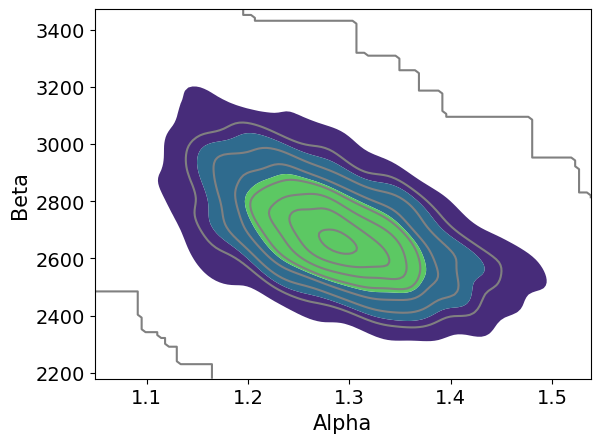

In [38]:
az.plot_pair(TraceWeibull, var_names=["Alpha", "Beta"], kind="kde")

<Axes: title={'center': 'MedianTime'}>

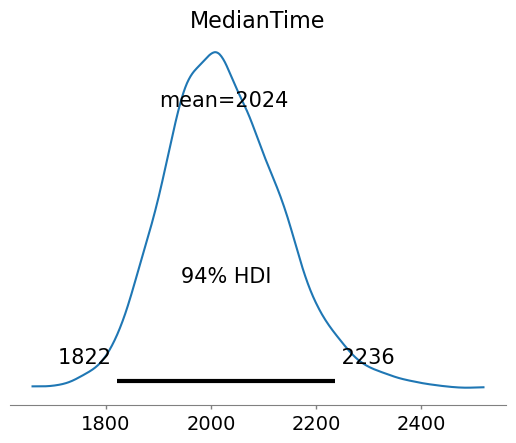

In [39]:
az.plot_posterior(TraceWeibull, var_names="MedianTime")

In [40]:
t_vect = np.linspace(0, 2659)

In [41]:
for t in t_vect:
    if t==t_vect[0]:
        Survivor = az.summary(
            WeibullSurvivor(
                t,
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Survivor = pd.concat([
            Survivor,
            az.summary(
                WeibullSurvivor(
                    t,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])
        
Survivor['time'] = t_vect

<Axes: xlabel='timeline'>

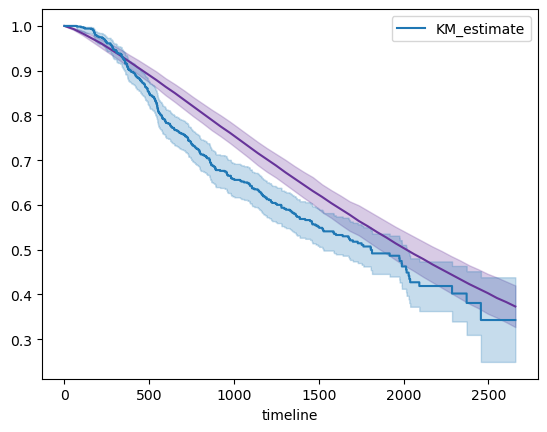

In [42]:
plt.plot(Survivor["time"], Survivor["mean"], color='rebeccapurple')
plt.fill_between(
    Survivor["time"],
    Survivor["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)
kmf.plot_survival_function()

In [48]:
# Extract posterior samples for Alpha and Beta
alpha_samples = TraceWeibull.posterior["Alpha"].values.flatten()
beta_samples = TraceWeibull.posterior["Beta"].values.flatten()

# Compute posterior predictive median for each sample
# TimeQuantile(0.5, Alpha, Beta) = beta * (ln(2))**(1/alpha)
posterior_medians = beta_samples * (np.log(2))**(1 / alpha_samples)

# Get the **mean** predicted median time across posterior
predicted_median = posterior_medians.mean()

# Calculate RMSE using test set
rmse_train = np.sqrt(mean_squared_error(ObservedTimes_train, [predicted_median] * len(ObservedTimes_train)))
rmse_test = np.sqrt(mean_squared_error(ObservedTimes_test, [predicted_median] * len(ObservedTimes_test)))

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

Train RMSE: 1285.79
Test RMSE: 1434.07


In [50]:
from lifelines.utils import concordance_index

# Step 1: Extract survival times and event status for observed data
times = data.loc[data["status"] == 1, "time"].values
status = data.loc[data["status"] == 1, "status"].values  # should be all 1s for observed

# Step 2: Use predicted median survival time from the posterior
# (same predicted_median you've already computed)
risk_scores = -predicted_median * np.ones_like(times)  # Negative since lower score = higher risk

# Step 3: Compute C-index
c_index = concordance_index(times, risk_scores, status)
print(f"Concordance Index: {c_index:.3f}")

Concordance Index: 0.500


In [55]:
print(risk_scores)

[-2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38432756 -2024.38432756 -2024.38432756
 -2024.38432756 -2024.38